# Setup

In [ ]:
!pip install osfclient --quiet
!pip install git+https://github.com/jspsych/eyetracking-utils.git --quiet
!pip install keras_cv --quiet
!pip install plotnine --quiet
!pip install wandb --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 38.0 MB/s eta 0:00:00


In [ ]:
import os
import tensorflow as tf
import numpy as np
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow.keras as keras
import keras_cv
from plotnine import ggplot, geom_point, aes, geom_line, scale_y_reverse, theme_void, scale_color_manual
import pandas as pd
import wandb
from wandb.integration.keras import WandbMetricsLogger

import matplotlib.pyplot as plt
from google.colab import userdata


import et_util.dataset_utils as dataset_utils
import et_util.embedding_preprocessing as embed_pre
import et_util.model_layers as model_layers
from et_util import experiment_utils
from et_util.custom_loss import normalized_weighted_euc_dist
from et_util.model_analysis import plot_model_performance

In [ ]:
os.environ['WANDB_API_KEY'] = userdata.get('WANDB_API_KEY')
os.environ['OSF_TOKEN'] = userdata.get('osftoken')
os.environ['OSF_USERNAME'] = userdata.get('osfusername')

In [ ]:
userdata.get('osftoken')

'Cvv9AY4YAA43Lb17ua0cbUr0G4OAv5mvFmegj7RK8e3k4vJZt5H7AihU6nvJxVQdkdxeW3'

In [ ]:
keras.mixed_precision.set_global_policy('mixed_float16')

# Configure W&B experiment

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joshdeleeuw (eye-tracking) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
EMBEDDING_DIM = 200
RIDGE_REGULARIZATION = 0.1
TRAIN_EPOCHS = 30
MIN_CAL_POINTS = 8
MAX_CAL_POINTS = 40
DENSE_NET_STACKWISE_NUM_REPEATS = [4,4,4]
LEARNING_RATE = 0.001

In [ ]:
config = {
    "embedding_dim": EMBEDDING_DIM,
    "ridge_regularization": RIDGE_REGULARIZATION,
    "train_epochs": TRAIN_EPOCHS,
    "min_cal_points": MIN_CAL_POINTS,
    "max_cal_points": MAX_CAL_POINTS,
    "dense_net_stackwise_num_repeats": DENSE_NET_STACKWISE_NUM_REPEATS,
    "learning_rate": LEARNING_RATE,
    "augmentation": True
}

In [ ]:
run = wandb.init(
    project='eye-tracking-dense-full-data-set-single-eye',
    config=config
)

# Download dataset from OSF

In [ ]:
!osf -p 6b5cd fetch single_eye_tfrecords.tar.gz

100% 2.50G/2.50G [02:11<00:00, 19.0Mbytes/s]


# Process raw data records into TF Dataset

In [ ]:
!mkdir single_eye_tfrecords
!tar -xf single_eye_tfrecords.tar.gz -C single_eye_tfrecords

In [ ]:
def parse(element):
    """Process function that parses a tfr element in a raw dataset for process_tfr_to_tfds function.
    Gets mediapipe landmarks, raw image, image width, image height, subject id, and xy labels.
    Use for data generated with make_single_example_landmarks_and_jpg (i.e. data in
    jpg_landmarks_tfrecords.tar.gz)

    :param element: tfr element in raw dataset
    :return: image, label(x,y), landmarks, subject_id
    """

    data_structure = {
        'landmarks': tf.io.FixedLenFeature([], tf.string),
        'img_width': tf.io.FixedLenFeature([], tf.int64),
        'img_height': tf.io.FixedLenFeature([], tf.int64),
        'x': tf.io.FixedLenFeature([], tf.float32),
        'y': tf.io.FixedLenFeature([], tf.float32),
        'eye_img': tf.io.FixedLenFeature([], tf.string),
        'subject_id': tf.io.FixedLenFeature([], tf.int64),
    }

    content = tf.io.parse_single_example(element, data_structure)

    landmarks = content['landmarks']
    raw_image = content['eye_img']
    width = content['img_width']
    height = content['img_height']
    depth = 3
    label = [content['x'], content['y']]
    subject_id = content['subject_id']

    landmarks = tf.io.parse_tensor(landmarks, out_type=tf.float32)
    landmarks = tf.reshape(landmarks, shape=(478, 3))

    image = tf.io.parse_tensor(raw_image, out_type=tf.uint8)

    return image, landmarks, label, subject_id

In [ ]:
train_data, validation_data, test_data = dataset_utils.process_tfr_to_tfds(
    'single_eye_tfrecords/',
    parse,
    train_split=1.0,
    val_split=0.0,
    test_split=0.0,
    random_seed=12604,
    group_function=lambda img, landmarks, coords, z: z
)

## Rescale the `x,y` coordinates to be 0-1 instead of 0-100.

In [ ]:
def rescale_coords_map(eyes, mesh, coords, id):
  return eyes, mesh, tf.divide(coords, tf.constant([100.])), id

In [ ]:
train_data_rescaled = train_data.map(rescale_coords_map)
validation_data_rescaled = validation_data.map(rescale_coords_map)

# Generate dataset that has calibration points, target point, and target output

Cols = 5, 11, 17, 23, 29, 35, 41, 47, 53, 59, 65, 71, 77, 83, 89, 95

Rows = 5, 16.25, 27.5, 38.75, 50, 61.25, 72.5, 83.75, 95  


Fixed Points as calibration

In [ ]:
cal_points = tf.constant([
    [5, 5],
    [5, 27.5],
    [5, 50],
    [5, 72.5],
    [5, 95],
    [35, 5],
    [35, 27.5],
    [35, 50],
    [35, 72.5],
    [35, 95],
    [65, 5],
    [65, 27.5],
    [65, 50],
    [65, 72.5],
    [65, 95],
    [95, 5],
    [95, 27.5],
    [95, 50],
    [95, 72.5],
    [95, 95],
], dtype=tf.float32)

scaled_cal_points = tf.divide(cal_points, tf.constant([100.]))

def filter_cal_points(image, mesh, coords, id):

  return tf.reduce_any(tf.reduce_all(tf.equal(coords, scaled_cal_points), axis=1))

def filter_non_cal_points(image, mesh, coords, id):

  return tf.reduce_all(tf.reduce_any(tf.not_equal(coords, scaled_cal_points), axis=1))

def filter_subjects_missing_cal_points(cal, target):

  return tf.equal(tf.shape(cal[0])[0], tf.shape(cal_points)[0])

def map_for_calibration_pts(image, mesh, coords, id):

  img = tf.reshape(image, (-1, 36, 144, 1))

  return img, coords

def map_for_non_calibration_pts(image, mesh, coords, id):

  img = tf.reshape(image, (-1, 36, 144, 1))

  return img, coords

def map_for_merged(cal, non_cal):
  target_input, target_output = non_cal

  return (*cal, target_input), target_output

def map_for_merged_with_id(cal, non_cal, id):
  target_input, target_output = non_cal

  return (*cal, target_input), target_output, id

def reducer_function(k, ds):

  ds_random = ds.shuffle(144)

  n_cal_points = tf.random.uniform(shape=[], minval=MIN_CAL_POINTS, maxval=MAX_CAL_POINTS, dtype=tf.int64)

  calibration_points = ds_random.take(n_cal_points).batch(n_cal_points).map(map_for_calibration_pts).repeat()

  non_calibration_points = ds.batch(144).map(map_for_non_calibration_pts)

  merged = tf.data.Dataset.zip(calibration_points, non_calibration_points)
  #return non_calibration_points
  #return merged
  return merged.map(map_for_merged)

# group data by subject id, create datasets with calibration points
def reducer_function_fixed_pts(subject_id, ds):

  non_cal_points = ds.batch(144, drop_remainder=True).map(map_for_non_calibration_pts)

  points = ds.filter(filter_cal_points).batch(len(cal_points), drop_remainder=True).map(map_for_calibration_pts).repeat()

  merged = tf.data.Dataset.zip(points, non_cal_points)
  #return merged
  return merged.map(map_for_merged)

def reducer_function_fixed_pts_with_id(subject_id, ds):

  non_cal_points = ds.batch(144, drop_remainder=True).map(map_for_non_calibration_pts)

  points = ds.filter(filter_cal_points).batch(len(cal_points)).map(map_for_calibration_pts).repeat()

  merged = tf.data.Dataset.zip(points, non_cal_points)

  #return merged
  return merged.map(lambda x, y: map_for_merged_with_id(x, y, subject_id))

## Create augmentation pipeline

In [33]:
#Create a preprocessing model
augmentation_model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1.0/255),
  tf.keras.layers.RandomBrightness(factor=0.1, value_range=(0,1)),
  tf.keras.layers.RandomContrast(factor=0.1),
  tf.keras.layers.RandomRotation(factor=0.05, fill_mode='constant'),
  tf.keras.layers.RandomTranslation(0.05, 0.05, fill_mode='constant'),
  tf.keras.layers.RandomZoom(
      height_factor=(-0.05, 0.05),
      width_factor=None,
      fill_mode='constant'
  ),
  tf.keras.layers.GaussianNoise(0.01)
])

@tf.function
def augment_with_model(x, y):
  cal_imgs, cal_coords, target_imgs = x

  # Apply augmentation model
  cal_imgs = augmentation_model(cal_imgs, training=True)
  target_imgs = augmentation_model(target_imgs, training=True)

  return (cal_imgs, cal_coords, target_imgs), y





In [32]:
t1.element_spec

((TensorSpec(shape=(None, 36, 144, 1), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 36, 144, 1), dtype=tf.uint8, name=None)),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

In [37]:
t0 = train_data_rescaled.cache()

t1 = t0.group_by_window(
    key_func = lambda img, m, c, z: z,
    reduce_func = reducer_function,
    window_size = 200
).prefetch(tf.data.AUTOTUNE)

t2 = t0.group_by_window(
    key_func = lambda img, m, c, z: z,
    reduce_func = reducer_function_fixed_pts_with_id,
    window_size = 200
)

# Apply to dataset
train_ds = t1.map(
    augment_with_model,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

# v = validation_data_rescaled.group_by_window(
#     key_func = lambda img, m, c, z: z,
#     reduce_func = reducer_function_fixed_pts_with_id,
#     window_size = 200
# ).cache().prefetch(tf.data.AUTOTUNE)

## Visualize augmentation

OperatorNotAllowedInGraphError: in user code:

    File "<ipython-input-33-8d9ae6000671>", line 18, in augment_with_model  *
        cal_imgs, cal_coords, target_imgs = x

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.


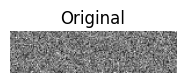

In [36]:
def visualize_augmentations(dataset, num_examples=5):
    """Visualize augmentations from a tf.data.Dataset"""
    # Get a sample image
    for x, y in t1.take(1):
        sample_image = x[0][0]  # First image in the batch

    # Create a figure to display results
    plt.figure(figsize=(15, 3))

    # Show original (normalized)
    plt.subplot(1, num_examples+1, 1)
    plt.imshow(sample_image.numpy().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Create a dataset with just our sample image
    single_image_ds = tf.data.Dataset.from_tensors((sample_image, 0))

    # Apply augmentation multiple times
    augmented_ds = single_image_ds.repeat(num_examples).map(augment_with_model)

    # Display augmented versions
    for i, (aug_img, _) in enumerate(augmented_ds.take(num_examples)):
        plt.subplot(1, num_examples+1, i+2)
        plt.imshow(aug_img.numpy().squeeze(), cmap='gray')
        plt.title(f"Aug {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use this to check your augmentations
visualize_augmentations(train_ds)

# Construct Model



## Eye image processing

In [38]:
def create_embedding_model():
    input_eyes = keras.layers.Input(shape=(36,144,1))

    # Continue with the backbone
    backbone = keras_cv.models.DenseNetBackbone(
        include_rescaling=False,
        input_shape=(36,144,1),
        stackwise_num_repeats=DENSE_NET_STACKWISE_NUM_REPEATS
    )
    backbone_encoder = backbone(input_eyes)

    flatten_compress = keras.layers.Flatten()(backbone_encoder)
    eye_embedding = keras.layers.Dense(units=EMBEDDING_DIM, activation="tanh")(flatten_compress)

    embedding_model = keras.Model(inputs=input_eyes, outputs=eye_embedding, name="Eye_Image_Embedding")

    return embedding_model

## Regression Layer

In [39]:
class WeightedRidgeRegressionLayer(keras.layers.Layer):
    def __init__(self, lambda_ridge, epsilon=1e-6, **kwargs):
        self.lambda_ridge = lambda_ridge
        self.epsilon = epsilon
        super(WeightedRidgeRegressionLayer, self).__init__(**kwargs)

    @tf.function(jit_compile=True)
    def call(self, inputs):
        unknown_embeddings, calibration_embeddings, calibration_coords, weights = inputs

        X = tf.cast(calibration_embeddings, tf.float32)  # (batch_size, n_calibration, 20)
        y = tf.cast(calibration_coords, tf.float32)  # (batch_size, n_calibration, 2)
        w = tf.cast(weights, tf.float32)  # (batch_size, n_calibration)

        # Add assertions
        # tf.debugging.assert_rank(X, 3, "calibration_embeddings should be rank 3")
        # tf.debugging.assert_rank(y, 3, "calibration_coords should be rank 3")
        # tf.debugging.assert_rank(w, 2, "weights should be rank 2")
        # tf.debugging.assert_non_negative(w, "weights should be non-negative")
        # tf.debugging.assert_less_equal(w, 1.0, "weights should be less than or equal to 1")

        # Compute weighted ridge regression coefficients
        n, p = X.shape[-2:]  # n_calibration, 20
        I = tf.eye(p, dtype=X.dtype)

        # Apply weights to X and y
        w_sqrt = tf.sqrt(w)
        X_weighted = X * tf.expand_dims(w_sqrt, axis=-1)  # (batch_size, n_calibration, 20)
        y_weighted = y * tf.expand_dims(w_sqrt, axis=-1)  # (batch_size, n_calibration, 2)

        X_t = tf.transpose(X_weighted, perm=[0, 2, 1])  # (batch_size, 20, n_calibration)
        X_t_X = tf.linalg.matmul(X_t, X_weighted)  # (batch_size, 20, 20)
        lhs = X_t_X + (self.lambda_ridge + self.epsilon) * I  # (batch_size, 20, 20)
        rhs = tf.linalg.matmul(X_t, y_weighted)  # (batch_size, 20, 2)

        kernel = tf.linalg.solve(lhs, rhs)  # (batch_size, 20, 2)

        # Apply regression to unknown point
        unknown_embeddings = tf.cast(unknown_embeddings, tf.float32)
        output = tf.linalg.matmul(unknown_embeddings, tf.transpose(kernel, perm=[0, 2, 1]), adjoint_b=True)  # (batch_size, ?, 2)
        return output

    def compute_output_shape(self, input_shapes):
        unknown_embeddings_shape, _, _, _ = input_shapes
        return unknown_embeddings_shape[:-1] + (2,)

    def get_config(self):
        config = super(WeightedRidgeRegressionLayer, self).get_config()
        config.update({"lambda_ridge": self.lambda_ridge, "epsilon": self.epsilon})
        return config

In [40]:
def create_full_model():

  embedding_model = create_embedding_model()

  input_calibration_eyes = keras.layers.Input(shape=(None,36,144,1), name="Input_Calibration_Eyes")
  input_calibration_points = keras.layers.Input(shape=(None,2,), name="Input_Calibration_Points")

  input_target_eyes = keras.layers.Input(shape=(None,36,144,1), name="Input_Target_Eyes")

  target_embedding = keras.layers.TimeDistributed(embedding_model)(input_target_eyes)
  calibration_embeddings = keras.layers.TimeDistributed(embedding_model)(input_calibration_eyes)

  calibration_weights = keras.layers.Dense(1, activation="sigmoid", name="Calibration_Weights")(calibration_embeddings)
  calibration_weights_reshaped = keras.layers.Reshape((-1,), name="Calibration_Weights_Reshaped")(calibration_weights)

  ridge = WeightedRidgeRegressionLayer(RIDGE_REGULARIZATION)([target_embedding, calibration_embeddings, input_calibration_points, calibration_weights_reshaped])

  full_model = keras.Model(inputs=[
    input_calibration_eyes,
    input_calibration_points,
    input_target_eyes
  ], outputs=ridge, name="FullEyePredictionModel")

  return full_model


## Full trainable model

In [44]:
full_model = create_full_model()

full_model.summary()

full_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=normalized_weighted_euc_dist,
    metrics=[normalized_weighted_euc_dist],
    jit_compile = False
)

Model: "FullEyePredictionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Calibration_Eyes    │ (None, None, 36, 144,  │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_12 (Cast)            │ (None, None, 36, 144,  │              0 │ Input_Calibration_Eye… │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_Target_Eyes         │ (None, None, 36, 144,  │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_5        │ (None, None, 200)      │      1,581,896 │ cast_12[0][0]          │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_11 (Cast)            │ (None, None, 36, 144,  │              0 │ Input_Target_Eyes[0][… │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Input_Calibration_Points  │ (None, None, 2)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Calibration_Weights       │ (None, None, 1)        │            201 │ time_distributed_5[0]… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, None, 200)      │      1,581,896 │ cast_11[0][0]          │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_13 (Cast)            │ (None, None, 2)        │              0 │ Input_Calibration_Poi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Calibration_Weights_Resh… │ (None, None)           │              0 │ Calibration_Weights[0… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ weighted_ridge_regressio… │ (None, None, 2)        │              0 │ time_distributed_4[0]… │
│ (WeightedRidgeRegression… │                        │                │ time_distributed_5[0]… │
│                           │                        │                │ cast_13[0][0],         │
│                           │                        │                │ Calibration_Weights_R… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,582,097 (6.04 MB)

 Trainable params: 1,574,257 (6.01 MB)

 Non-trainable params: 7,840 (30.62 KB)

In [42]:
def lr_schedule(epoch):
  if epoch < 15:
    return LEARNING_RATE
  else:
    return LEARNING_RATE * 0.1

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# Train model

In [45]:
train_history = full_model.fit(train_ds.batch(1), epochs=TRAIN_EPOCHS, callbacks=[WandbMetricsLogger(), lr_scheduler])
#full_model.fit(t1.batch(1), epochs=TRAIN_EPOCHS)

Epoch 1/30
1726/1726 ━━━━━━━━━━━━━━━━━━━━ 593s 320ms/step - loss: 0.2662 - normalized_weighted_euc_dist: 0.2662 - learning_rate: 0.0010
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


 169/1726 ━━━━━━━━━━━━━━━━━━━━ 5:29 212ms/step - loss: 0.2618 - normalized_weighted_euc_dist: 0.2618

KeyboardInterrupt: 

In [ ]:
full_model.save('full_model.keras')

In [ ]:
full_model.save_weights('full_model.weights.h5')

In [ ]:
wandb.save('full_model.keras')
wandb.save('full_model.weights.h5')

['/content/wandb/run-20241221_135150-2rlxy5dx/files/full_model.weights.h5']

In [ ]:
# Initialize a list to store the batch losses
batch_losses = []
subject_ids = []
y_true = []

for e in t2.batch(1).as_numpy_iterator():

    y_true.append(e[1])
    subject_ids.append(e[2][0])

y_true = np.array(y_true).reshape(-1, 144, 2)

# this step is slower than expected. not sure what's going on.
predictions = full_model.predict(t2.batch(1))

for i in range(len(predictions)):
  loss = normalized_weighted_euc_dist(y_true[i], predictions[i]).numpy()
  batch_losses.append(loss)

batch_losses = np.array(batch_losses)

# Get mean per subject
batch_losses = np.mean(batch_losses, axis=1)

1564/1564 ━━━━━━━━━━━━━━━━━━━━ 807s 421ms/step


In [ ]:
final_loss_table = wandb.Table(data=[[s, l] for (s, l) in zip(subject_ids, batch_losses)], columns=["subject", "scores"])

In [ ]:
final_loss_hist = wandb.plot.histogram(final_loss_table, "scores", title="Normalized Euclidean Distance")

In [ ]:
final_loss_mean = np.mean(batch_losses)

In [ ]:
wandb.log({"final_val_loss_table": final_loss_table, "final_val_loss_hist": final_loss_hist, "final_loss_mean": final_loss_mean})

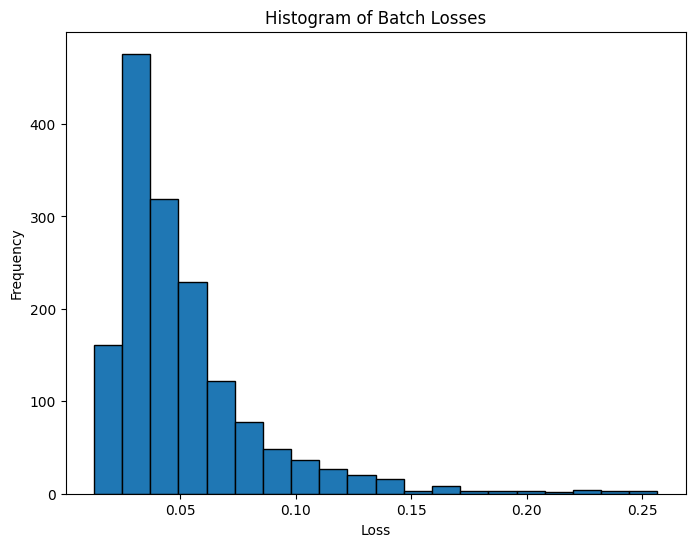

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(batch_losses, bins=20, edgecolor='black')
plt.title('Histogram of Batch Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.show()

In [ ]:
wandb.finish()

epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,███████████████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/normalized_weighted_euc_dist,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
final_loss_mean,▁
epoch/epoch,29
epoch/learning_rate,0.0001
epoch/loss,0.04859
epoch/normalized_weighted_euc_dist,0.04859
final_loss_mean,0.05181
